In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools
import scipy
from tqdm.auto import tqdm

plt.style.use('cms')
plt.rcParams.update({
    "figure.dpi": 150,
    "figure.figsize": (4, 3),
    "lines.markersize": 3,
    "errorbar.capsize": 2,
    "font.size": 10.,
})

In [20]:
df_data_para = pd.read_hdf("fit_results.h5", "METnoX_ptParaZCandCent_DataFitResults")
df_mc_para = pd.read_hdf("fit_results.h5", "METnoX_ptParaZCandCent_MCFitResults")
df_mc_para_systs = pd.read_hdf("fit_results.h5", "METnoX_ptParaZCandCent_MCFitSysts")
df_data_perp = pd.read_hdf("fit_results.h5", "METnoX_ptPerpZCandCent_DataFitResults")
df_mc_perp = pd.read_hdf("fit_results.h5", "METnoX_ptPerpZCandCent_MCFitResults")
df_mc_perp_systs = pd.read_hdf("fit_results.h5", "METnoX_ptPerpZCandCent_MCFitSysts")

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.


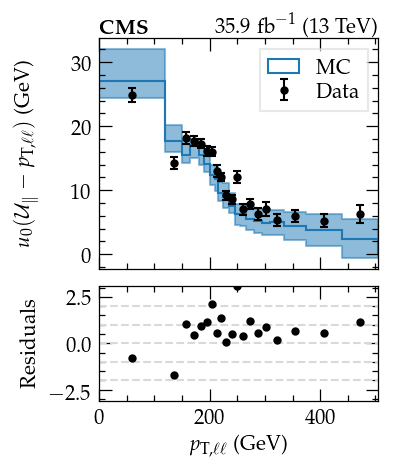

In [21]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "wspace": 0.1, "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_ylabel(r'$u_0(\mathcal{U}_{\parallel}-p_{\mathrm{T},\ell\ell})$ (GeV)')
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
fig.align_labels(ax)

bin_min = df_data_para.index.get_level_values("binvar0_min")
bin_max = np.array(list(bin_min[1:]) + [2*bin_min[-1]-bin_min[-2]])
ax[0].set_xlim(bin_min[0], bin_max[-1])

data = df_data_para["x0"]
ax[0].errorbar(
    (bin_min + bin_max)/2.,
    df_data_para["x0"],
    yerr=(np.abs(df_data_para["x0_down"]), df_data_para["x0_up"]),
    fmt='o', color='black',
    label="Data",
)

df_cent = df_mc_para.loc[("", "down")]
df_x0_syst_diff = pd.pivot_table(
    df_mc_para.loc[
        ~(df_mc_para.index.get_level_values("variation")==""),:
    ], values=["x0"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["x0"], axis=0).stack()

df_x0_cent = df_cent[["x0_down", "x0_up"]]
df_x0_cent.columns = ["down", "up"]
df_x0_cent = df_x0_cent.reset_index()
df_x0_cent["variation"] = "stat"
df_x0_cent = df_x0_cent.set_index(["binvar0_min", "binvar0_max", "variation"])
df_x0_syst_diff.columns = [c[1] for c in df_x0_syst_diff.columns]

df_x0_unc_diff = pd.concat([df_x0_cent, df_x0_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])

#for cat, dfgrp in np.abs(df_x0_unc_diff).max(axis=1).groupby(["binvar0_min", "binvar0_max"]):
#    print(dfgrp.sort_values(ascending=False).head(5))

df_x0_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_x0_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_x0_unc_diff.max(axis=1)),
}, index=df_x0_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())
#df_x0_unc_diff_total

mc = df_cent["x0"]
ax[0].hist(
    bin_min,
    bins=list(bin_min)+[bin_max[-1]],
    weights=df_cent["x0"],
    histtype='step', color='#1f78b4',
    label="MC",
)

up = list(df_cent["x0"] + df_x0_unc_diff_total["up"])
down = list(df_cent["x0"] - df_x0_unc_diff_total["down"])
ax[0].fill_between(
    list(bin_min)+[bin_max[-1]],
    up+[up[-1]], down+[down[-1]],
    step='post', color='#1f78b4',
    alpha=0.5,
)

sigma = np.sqrt(df_x0_unc_diff_total["up"]**2 + df_data_para["x0_down"]**2)
mask = ((data - mc)<0.)
sigma[mask] = np.sqrt(df_x0_unc_diff_total.loc[mask, "down"]**2 + df_data_para["x0_up"]**2)
ax[1].errorbar(
    (bin_min + bin_max)/2.,
    (data - mc) / sigma,
    fmt='o', color='black',
)
ax[1].set_ylim(-3.1, 3.1)
ax[1].axhline(0., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(2., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-2., color='#d9d9d9', ls='--', lw=1)

ax[0].legend(loc=1, labelspacing=0.1, edgecolor='#d9d9d9')

fig.savefig("plots/metres_mm_u0_para.pdf", format='pdf', bbox_inches='tight')
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.


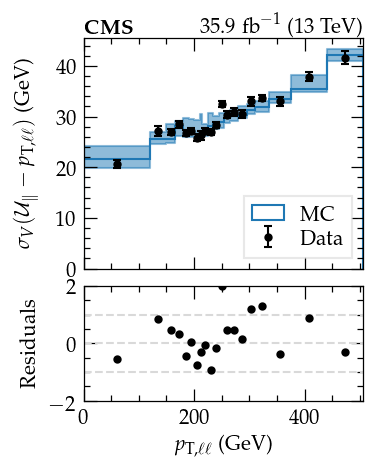

In [22]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "wspace": 0.1, "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_ylabel(r'$\sigma_V(\mathcal{U}_{\parallel}-p_{\mathrm{T},\ell\ell})$ (GeV)')
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
fig.align_labels(ax)

bin_min = df_data_para.index.get_level_values("binvar0_min")
bin_max = np.array(list(bin_min[1:]) + [2*bin_min[-1]-bin_min[-2]])
ax[0].set_xlim(bin_min[0], bin_max[-1])

data = df_data_para["sigmav"]
ax[0].errorbar(
    (bin_min + bin_max)/2.,
    df_data_para["sigmav"],
    yerr=(np.abs(df_data_para["sigmav_down"]), df_data_para["sigmav_up"]),
    fmt='o', color='black',
    label="Data",
)

df_cent = df_mc_para.loc[("", "down")]
df_sigmav_syst_diff = pd.pivot_table(
    df_mc_para.loc[
        ~(df_mc_para.index.get_level_values("variation")==""),:
    ], values=["sigmav"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["sigmav"], axis=0).stack()

df_sigmav_cent = df_cent[["sigmav_down", "sigmav_up"]]
df_sigmav_cent.columns = ["down", "up"]
df_sigmav_cent = df_sigmav_cent.reset_index()
df_sigmav_cent["variation"] = "stat"
df_sigmav_cent = df_sigmav_cent.set_index(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_syst_diff.columns = [c[1] for c in df_sigmav_syst_diff.columns]

df_sigmav_unc_diff = pd.concat([df_sigmav_cent, df_sigmav_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_sigmav_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_sigmav_unc_diff.max(axis=1)),
}, index=df_sigmav_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())
df_sigmav_unc_diff_total

mc = df_cent["sigmav"]
ax[0].hist(
    bin_min,
    bins=list(bin_min)+[bin_max[-1]],
    weights=df_cent["sigmav"],
    histtype='step', color='#1f78b4',
    label="MC",
)

up = list(df_cent["sigmav"] + df_sigmav_unc_diff_total["up"])
down = list(df_cent["sigmav"] - df_sigmav_unc_diff_total["down"])
ax[0].fill_between(
    list(bin_min)+[bin_max[-1]],
    up+[up[-1]], down+[down[-1]],
    step='post', color='#1f78b4',
    alpha=0.5,
)

sigma = np.sqrt(df_sigmav_unc_diff_total["up"]**2 + df_data_para["sigmav_down"]**2)
mask = ((data - mc)<0.)
sigma[mask] = np.sqrt(df_sigmav_unc_diff_total.loc[mask, "down"]**2 + df_data_para["sigmav_up"]**2)
ax[1].errorbar(
    (bin_min + bin_max)/2.,
    (data - mc) / sigma,
    fmt='o', color='black',
)
ax[1].set_ylim(-2, 2)
ax[1].axhline(0., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-1., color='#d9d9d9', ls='--', lw=1)

ax[0].legend(loc=4, labelspacing=0.1, edgecolor='#d9d9d9')

fig.savefig("plots/metres_mm_sigmav_para.pdf", format='pdf', bbox_inches='tight')
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.


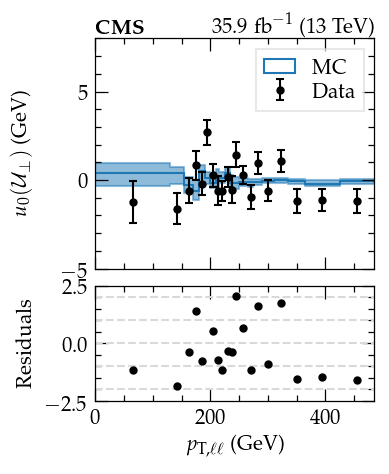

In [5]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "wspace": 0.1, "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_ylabel(r'$u_0(\mathcal{U}_{\perp})$ (GeV)')
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
fig.align_labels(ax)

bin_min = df_data_perp.index.get_level_values("binvar0_min")
bin_max = np.array(list(bin_min[1:]) + [2*bin_min[-1]-bin_min[-2]])
ax[0].set_xlim(bin_min[0], bin_max[-1])

data = df_data_perp["x0"]
ax[0].errorbar(
    (bin_min + bin_max)/2.,
    df_data_perp["x0"],
    yerr=(np.abs(df_data_perp["x0_down"]), df_data_perp["x0_up"]),
    fmt='o', color='black',
    label="Data",
)

df_cent = df_mc_perp.loc[("", "down")]
df_x0_syst_diff = pd.pivot_table(
    df_mc_perp.loc[
        ~(df_mc_perp.index.get_level_values("variation")==""),:
    ], values=["x0"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["x0"], axis=0).stack()

df_x0_cent = df_cent[["x0_down", "x0_up"]]
df_x0_cent.columns = ["down", "up"]
df_x0_cent = df_x0_cent.reset_index()
df_x0_cent["variation"] = "stat"
df_x0_cent = df_x0_cent.set_index(["binvar0_min", "binvar0_max", "variation"])
df_x0_syst_diff.columns = [c[1] for c in df_x0_syst_diff.columns]

df_x0_unc_diff = pd.concat([df_x0_cent, df_x0_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_x0_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_x0_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_x0_unc_diff.max(axis=1)),
}, index=df_x0_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())
df_x0_unc_diff_total

mc = df_cent["x0"]
ax[0].hist(
    bin_min,
    bins=list(bin_min)+[bin_max[-1]],
    weights=df_cent["x0"],
    histtype='step', color='#1f78b4',
    label="MC",
)

up = list(df_cent["x0"] + df_x0_unc_diff_total["up"])
down = list(df_cent["x0"] - df_x0_unc_diff_total["down"])
ax[0].fill_between(
    list(bin_min)+[bin_max[-1]],
    up+[up[-1]], down+[down[-1]],
    step='post', color='#1f78b4',
    alpha=0.5,
)

sigma = np.sqrt(df_x0_unc_diff_total["up"]**2 + df_data_perp["x0_down"]**2)
mask = ((data - mc)<0.)
sigma[mask] = np.sqrt(df_x0_unc_diff_total.loc[mask, "down"]**2 + df_data_perp["x0_up"]**2)
ax[1].errorbar(
    (bin_min + bin_max)/2.,
    (data - mc) / sigma,
    fmt='o', color='black',
)
ax[1].set_ylim(-2.5, 2.5)
#ax[1].set_ylim(-3, 3)
ax[1].axhline(0., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(2., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-2., color='#d9d9d9', ls='--', lw=1)

ax[0].legend(loc=1, labelspacing=0.1, edgecolor='#d9d9d9')

ax[0].set_ylim(-5., 8.)
fig.savefig("plots/metres_mm_u0_perp.pdf", format='pdf', bbox_inches='tight')
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.


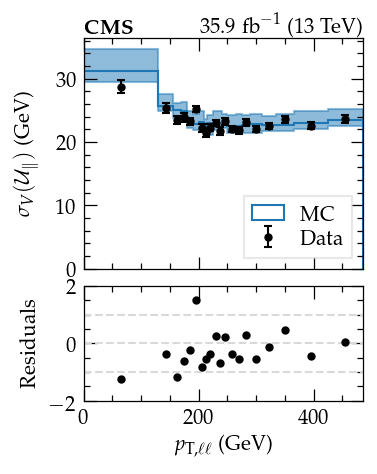

In [6]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "wspace": 0.1, "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_ylabel(r'$\sigma_V(\mathcal{U}_{\parallel})$ (GeV)')
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
fig.align_labels(ax)

bin_min = df_data_perp.index.get_level_values("binvar0_min")
bin_max = np.array(list(bin_min[1:]) + [2*bin_min[-1]-bin_min[-2]])
ax[0].set_xlim(bin_min[0], bin_max[-1])

data = df_data_perp["sigmav"]
ax[0].errorbar(
    (bin_min + bin_max)/2.,
    df_data_perp["sigmav"],
    yerr=(np.abs(df_data_perp["sigmav_down"]), df_data_perp["sigmav_up"]),
    fmt='o', color='black',
    label="Data",
)

df_cent = df_mc_perp.loc[("", "down")]
df_sigmav_syst_diff = pd.pivot_table(
    df_mc_perp.loc[
        ~(df_mc_perp.index.get_level_values("variation")==""),:
    ], values=["sigmav"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["sigmav"], axis=0).stack()

df_sigmav_cent = df_cent[["sigmav_down", "sigmav_up"]]
df_sigmav_cent.columns = ["down", "up"]
df_sigmav_cent = df_sigmav_cent.reset_index()
df_sigmav_cent["variation"] = "stat"
df_sigmav_cent = df_sigmav_cent.set_index(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_syst_diff.columns = [c[1] for c in df_sigmav_syst_diff.columns]

df_sigmav_unc_diff = pd.concat([df_sigmav_cent, df_sigmav_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_sigmav_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_sigmav_unc_diff.max(axis=1)),
}, index=df_sigmav_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())
df_sigmav_unc_diff_total

mc = df_cent["sigmav"]
ax[0].hist(
    bin_min,
    bins=list(bin_min)+[bin_max[-1]],
    weights=df_cent["sigmav"],
    histtype='step', color='#1f78b4',
    label="MC",
)

up = list(df_cent["sigmav"] + df_sigmav_unc_diff_total["up"])
down = list(df_cent["sigmav"] - df_sigmav_unc_diff_total["down"])
ax[0].fill_between(
    list(bin_min)+[bin_max[-1]],
    up+[up[-1]], down+[down[-1]],
    step='post', color='#1f78b4',
    alpha=0.5,
)

sigma = np.sqrt(df_sigmav_unc_diff_total["up"]**2 + df_data_perp["sigmav_down"]**2)
mask = ((data - mc)<0.)
sigma[mask] = np.sqrt(df_sigmav_unc_diff_total.loc[mask, "down"]**2 + df_data_perp["sigmav_up"]**2)
ax[1].errorbar(
    (bin_min + bin_max)/2.,
    (data - mc) / sigma,
    fmt='o', color='black',
)
ax[1].set_ylim(-2, 2)
ax[1].axhline(0., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-1., color='#d9d9d9', ls='--', lw=1)

ax[0].legend(loc=4, labelspacing=0.1, edgecolor='#d9d9d9')

fig.savefig("plots/metres_mm_sigmav_perp.pdf", format='pdf', bbox_inches='tight')
pass

In [7]:
df_data_para = pd.read_hdf("fit_results_ele.h5", "METnoX_ptParaZCandCent_DataFitResults")
df_mc_para = pd.read_hdf("fit_results_ele.h5", "METnoX_ptParaZCandCent_MCFitResults")
df_mc_para_systs = pd.read_hdf("fit_results_ele.h5", "METnoX_ptParaZCandCent_MCFitSysts")
df_data_perp = pd.read_hdf("fit_results_ele.h5", "METnoX_ptPerpZCandCent_DataFitResults")
df_mc_perp = pd.read_hdf("fit_results_ele.h5", "METnoX_ptPerpZCandCent_MCFitResults")
df_mc_perp_systs = pd.read_hdf("fit_results_ele.h5", "METnoX_ptPerpZCandCent_MCFitSysts")

KeyError: 'No object named METnoX_ptPerpZCandCent_DataFitResults in the file'

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.


ValueError: cannot handle a non-unique multi-index!

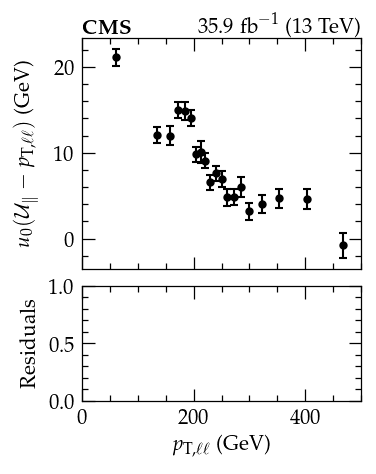

In [16]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "wspace": 0.1, "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_ylabel(r'$u_0(\mathcal{U}_{\parallel}-p_{\mathrm{T},\ell\ell})$ (GeV)')
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
fig.align_labels(ax)

bin_min = df_data_para.index.get_level_values("binvar0_min")
bin_max = np.array(list(bin_min[1:]) + [2*bin_min[-1]-bin_min[-2]])
ax[0].set_xlim(bin_min[0], bin_max[-1])

data = df_data_para["x0"]
ax[0].errorbar(
    (bin_min + bin_max)/2.,
    df_data_para["x0"],
    yerr=(np.abs(df_data_para["x0_down"]), df_data_para["x0_up"]),
    fmt='o', color='black',
    label="Data",
)

df_cent = df_mc_para.loc[("", "down")]
df_x0_syst_diff = pd.pivot_table(
    df_mc_para.loc[
        ~(df_mc_para.index.get_level_values("variation")==""),:
    ], values=["x0"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["x0"], axis=0).stack()

df_x0_cent = df_cent[["x0_down", "x0_up"]]
df_x0_cent.columns = ["down", "up"]
df_x0_cent = df_x0_cent.reset_index()
df_x0_cent["variation"] = "stat"
df_x0_cent = df_x0_cent.set_index(["binvar0_min", "binvar0_max", "variation"])
df_x0_syst_diff.columns = [c[1] for c in df_x0_syst_diff.columns]

df_x0_unc_diff = pd.concat([df_x0_cent, df_x0_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_x0_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_x0_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_x0_unc_diff.max(axis=1)),
}, index=df_x0_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())
df_x0_unc_diff_total

mc = df_cent["x0"]
ax[0].hist(
    bin_min,
    bins=list(bin_min)+[bin_max[-1]],
    weights=df_cent["x0"],
    histtype='step', color='#1f78b4',
    label="MC",
)

up = list(df_cent["x0"] + df_x0_unc_diff_total["up"])
down = list(df_cent["x0"] - df_x0_unc_diff_total["down"])
ax[0].fill_between(
    list(bin_min)+[bin_max[-1]],
    up+[up[-1]], down+[down[-1]],
    step='post', color='#1f78b4',
    alpha=0.5,
)

sigma = np.sqrt(df_x0_unc_diff_total["up"]**2 + df_data_para["x0_down"]**2)
mask = ((data - mc)<0.)
sigma[mask] = np.sqrt(df_x0_unc_diff_total.loc[mask, "down"]**2 + df_data_para["x0_up"]**2)
ax[1].errorbar(
    (bin_min + bin_max)/2.,
    (data - mc) / sigma,
    fmt='o', color='black',
)
ax[1].set_ylim(-2, 2)
ax[1].axhline(0., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-1., color='#d9d9d9', ls='--', lw=1)

ax[0].legend(loc=1, labelspacing=0.1, edgecolor='#d9d9d9')

fig.savefig("plots/metres_ee_u0_para.pdf", format='pdf', bbox_inches='tight')
pass

In [ ]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "wspace": 0.1, "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_ylabel(r'$\sigma_V(\mathcal{U}_{\parallel}-p_{\mathrm{T},\ell\ell})$ (GeV)')
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
fig.align_labels(ax)

bin_min = df_data_para.index.get_level_values("binvar0_min")
bin_max = np.array(list(bin_min[1:]) + [2*bin_min[-1]-bin_min[-2]])
ax[0].set_xlim(bin_min[0], bin_max[-1])

data = df_data_para["sigmav"]
ax[0].errorbar(
    (bin_min + bin_max)/2.,
    df_data_para["sigmav"],
    yerr=(np.abs(df_data_para["sigmav_down"]), df_data_para["sigmav_up"]),
    fmt='o', color='black',
    label="Data",
)

df_cent = df_mc_para.loc[("", "down")]
df_sigmav_syst_diff = pd.pivot_table(
    df_mc_para.loc[
        ~(df_mc_para.index.get_level_values("variation")==""),:
    ], values=["sigmav"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["sigmav"], axis=0).stack()

df_sigmav_cent = df_cent[["sigmav_down", "sigmav_up"]]
df_sigmav_cent.columns = ["down", "up"]
df_sigmav_cent = df_sigmav_cent.reset_index()
df_sigmav_cent["variation"] = "stat"
df_sigmav_cent = df_sigmav_cent.set_index(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_syst_diff.columns = [c[1] for c in df_sigmav_syst_diff.columns]

df_sigmav_unc_diff = pd.concat([df_sigmav_cent, df_sigmav_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_sigmav_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_sigmav_unc_diff.max(axis=1)),
}, index=df_sigmav_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())
df_sigmav_unc_diff_total

mc = df_cent["sigmav"]
ax[0].hist(
    bin_min,
    bins=list(bin_min)+[bin_max[-1]],
    weights=df_cent["sigmav"],
    histtype='step', color='#1f78b4',
    label="MC",
)

up = list(df_cent["sigmav"] + df_sigmav_unc_diff_total["up"])
down = list(df_cent["sigmav"] - df_sigmav_unc_diff_total["down"])
ax[0].fill_between(
    list(bin_min)+[bin_max[-1]],
    up+[up[-1]], down+[down[-1]],
    step='post', color='#1f78b4',
    alpha=0.5,
)

sigma = np.sqrt(df_sigmav_unc_diff_total["up"]**2 + df_data_para["sigmav_down"]**2)
mask = ((data - mc)<0.)
sigma[mask] = np.sqrt(df_sigmav_unc_diff_total.loc[mask, "down"]**2 + df_data_para["sigmav_up"]**2)
ax[1].errorbar(
    (bin_min + bin_max)/2.,
    (data - mc) / sigma,
    fmt='o', color='black',
)
ax[1].set_ylim(-2, 2)
ax[1].axhline(0., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-1., color='#d9d9d9', ls='--', lw=1)

ax[0].legend(loc=4, labelspacing=0.1, edgecolor='#d9d9d9')

fig.savefig("plots/metres_ee_sigmav_para.pdf", format='pdf', bbox_inches='tight')
pass

In [ ]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "wspace": 0.1, "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_ylabel(r'$u_0(\mathcal{U}_{\perp})$ (GeV)')
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
fig.align_labels(ax)

bin_min = df_data_perp.index.get_level_values("binvar0_min")
bin_max = np.array(list(bin_min[1:]) + [2*bin_min[-1]-bin_min[-2]])
ax[0].set_xlim(bin_min[0], bin_max[-1])

data = df_data_perp["x0"]
ax[0].errorbar(
    (bin_min + bin_max)/2.,
    df_data_perp["x0"],
    yerr=(np.abs(df_data_perp["x0_down"]), df_data_perp["x0_up"]),
    fmt='o', color='black',
    label="Data",
)

df_cent = df_mc_perp.loc[("", "down")]
df_x0_syst_diff = pd.pivot_table(
    df_mc_perp.loc[
        ~(df_mc_perp.index.get_level_values("variation")==""),:
    ], values=["x0"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["x0"], axis=0).stack()

df_x0_cent = df_cent[["x0_down", "x0_up"]]
df_x0_cent.columns = ["down", "up"]
df_x0_cent = df_x0_cent.reset_index()
df_x0_cent["variation"] = "stat"
df_x0_cent = df_x0_cent.set_index(["binvar0_min", "binvar0_max", "variation"])
df_x0_syst_diff.columns = [c[1] for c in df_x0_syst_diff.columns]

df_x0_unc_diff = pd.concat([df_x0_cent, df_x0_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_x0_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_x0_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_x0_unc_diff.max(axis=1)),
}, index=df_x0_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())
df_x0_unc_diff_total

mc = df_cent["x0"]
ax[0].hist(
    bin_min,
    bins=list(bin_min)+[bin_max[-1]],
    weights=df_cent["x0"],
    histtype='step', color='#1f78b4',
    label="MC",
)

up = list(df_cent["x0"] + df_x0_unc_diff_total["up"])
down = list(df_cent["x0"] - df_x0_unc_diff_total["down"])
ax[0].fill_between(
    list(bin_min)+[bin_max[-1]],
    up+[up[-1]], down+[down[-1]],
    step='post', color='#1f78b4',
    alpha=0.5,
)

sigma = np.sqrt(df_x0_unc_diff_total["up"]**2 + df_data_perp["x0_down"]**2)
mask = ((data - mc)<0.)
sigma[mask] = np.sqrt(df_x0_unc_diff_total.loc[mask, "down"]**2 + df_data_perp["x0_up"]**2)
ax[1].errorbar(
    (bin_min + bin_max)/2.,
    (data - mc) / sigma,
    fmt='o', color='black',
)
ax[1].set_ylim(-2, 2)
ax[1].axhline(0., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-1., color='#d9d9d9', ls='--', lw=1)

ax[0].legend(loc=1, labelspacing=0.1, edgecolor='#d9d9d9')

ax[0].set_ylim(-5., 8.)
fig.savefig("plots/metres_ee_u0_perp.pdf", format='pdf', bbox_inches='tight')
pass

In [ ]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "wspace": 0.1, "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_ylabel(r'$\sigma_V(\mathcal{U}_{\perp})$ (GeV)')
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
fig.align_labels(ax)

bin_min = df_data_perp.index.get_level_values("binvar0_min")
bin_max = np.array(list(bin_min[1:]) + [2*bin_min[-1]-bin_min[-2]])
ax[0].set_xlim(bin_min[0], bin_max[-1])

data = df_data_perp["sigmav"]
ax[0].errorbar(
    (bin_min + bin_max)/2.,
    df_data_perp["sigmav"],
    yerr=(np.abs(df_data_perp["sigmav_down"]), df_data_perp["sigmav_up"]),
    fmt='o', color='black',
    label="Data",
)

df_cent = df_mc_perp.loc[("", "down")]
df_sigmav_syst_diff = pd.pivot_table(
    df_mc_perp.loc[
        ~(df_mc_perp.index.get_level_values("variation")==""),:
    ], values=["sigmav"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["sigmav"], axis=0).stack()

df_sigmav_cent = df_cent[["sigmav_down", "sigmav_up"]]
df_sigmav_cent.columns = ["down", "up"]
df_sigmav_cent = df_sigmav_cent.reset_index()
df_sigmav_cent["variation"] = "stat"
df_sigmav_cent = df_sigmav_cent.set_index(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_syst_diff.columns = [c[1] for c in df_sigmav_syst_diff.columns]

df_sigmav_unc_diff = pd.concat([df_sigmav_cent, df_sigmav_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_sigmav_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_sigmav_unc_diff.max(axis=1)),
}, index=df_sigmav_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())
df_sigmav_unc_diff_total

mc = df_cent["sigmav"]
ax[0].hist(
    bin_min,
    bins=list(bin_min)+[bin_max[-1]],
    weights=df_cent["sigmav"],
    histtype='step', color='#1f78b4',
    label="MC",
)

up = list(df_cent["sigmav"] + df_sigmav_unc_diff_total["up"])
down = list(df_cent["sigmav"] - df_sigmav_unc_diff_total["down"])
ax[0].fill_between(
    list(bin_min)+[bin_max[-1]],
    up+[up[-1]], down+[down[-1]],
    step='post', color='#1f78b4',
    alpha=0.5,
)

sigma = np.sqrt(df_sigmav_unc_diff_total["up"]**2 + df_data_perp["sigmav_down"]**2)
mask = ((data - mc)<0.)
sigma[mask] = np.sqrt(df_sigmav_unc_diff_total.loc[mask, "down"]**2 + df_data_perp["sigmav_up"]**2)
ax[1].errorbar(
    (bin_min + bin_max)/2.,
    (data - mc) / sigma,
    fmt='o', color='black',
)
ax[1].set_ylim(-2, 2)
ax[1].axhline(0., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(1., color='#d9d9d9', ls='--', lw=1)
ax[1].axhline(-1., color='#d9d9d9', ls='--', lw=1)

ax[0].legend(loc=4, labelspacing=0.1, edgecolor='#d9d9d9')

fig.savefig("plots/metres_ee_sigmav_perp.pdf", format='pdf', bbox_inches='tight')
pass